In [1]:
# Created on Tue Feb 22 14:42:56 2022

# @author: uqczhan2
# if hydraulic conductivity of the sandy layer
# is reduced, the large hydraulic conductivity in the oscillating boundary
# needs to be redued accordingLy_m 

# To allow the graph to pop out run:
# get_ipython().run_line_magic('matplotlib', 'auto')
# To make the graph in the plot box, run:
# get_ipython().run_line_magic('matplotlib', 'inline')
# need to install: 
# pip install -U csaps
# CZ220319 this file is generated by running:

# jupytext --to notebook .\ewatering_mf6.py

# convert the jupyter back to py run 

# jupytext --to py notebook.ipynb   
# the command above is not good because it does not have sections as divided by '#%%'

#  jupyter nbconvert --to script .\ewatering_mf6_jupytext_trial.ipynb
#  above works as least it has sections.

#  jupyter nbconvert --to notebook .\ewatering_mf6_jupytext_trial_2.py


# jupytext was found to work better than p2j as the latter considers every blank line
# as cell divider, where as the former only treats '#%%' as divider.
# also when using jupytxext, ensure there is no other texts after #%% as they will be
# deleted.

# a video tutorial to this script can be accessible from:
# https://www.youtube.com/watch?v=33bVWu36miE&t=1s&ab_channel=ChenmingZhang
# https://www.youtube.com/watch?v=gDAkmN4vy4Q&ab_channel=ChenmingZhang 

In [2]:
#
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

# print the versions used to run this model, a important information to
# reproduce the result a couple of years later
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

# parameters for plotting
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
model_ws = os.path.join('.', 'data')

print('Model workspace is : {}'.format(os.getcwd()))

# a dot dict to group objects togeter
# https://stackoverflow.com/a/23689767/1744434
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.20.3
matplotlib version: 3.4.3
pandas version: 1.3.4
flopy version: 3.3.5
Model workspace is : D:\projects\ewatering\modflow_planar_2D


In [3]:
#unit conversion
mPmm = 0.001 # convert mm to m
sPday = 86400.
m2Pms = 1./9800000.
m2Pmday = m2Pms / sPday

In [4]:
# list of variables that currently used for sensitivity analysis
#kh_sand_mPday = 10.0 ; nlay = 1;sy = 0.25; strt_m = -5; kz_clay_mPday = 0.043 ; zbot_m = -20.  # best results; but recharge, overestimated
# because the recharge is overtestimated, we decied to putdown the k_clay 
# kh_sand_mPday = 10.0 ; nlay = 1;sy = 0.25; strt_m = -5; kz_clay_mPday = 0.000847 ; zbot_m = -20. 
#kh_sand_mPday = 10.0 ; nlay = 1;sy = 0.15; strt_m = -5; kz_clay_mPday = 0.000847 ; zbot_m = -20. 
#kh_sand_mPday = 10.0 ; nlay = 1;sy = 0.15; strt_m = -6; kz_clay_mPday = 0.000847 ; zbot_m = -10. # relative good outcome as the rise became instant
# caseid= 'aa'; kh_sand_mPday = 10.0 ; nlay = 1;sy = 0.10; strt_m = -6; kz_clay_mPday = 0.000847 ; zbot_m = -10.
#caseid= 'ac'; kh_sand_mPday = 5.0 ; nlay = 1;sy = 0.10; strt_m = -6; kz_clay_mPday = 0.000847 ; zbot_m = -10.
#caseid= 'ad'; kh_sand_mPday = 5.0 ; nlay = 1;sy = 0.10; strt_m = -6; kz_clay_mPday = 0.000847*2 ; zbot_m = -10.
#caseid= 'ae'; kh_sand_mPday = 2.5 ; nlay = 1;sy = 0.10; strt_m = -6; kz_clay_mPday = 0.000847*2 ; zbot_m = -10.
#caseid= 'ag'; kh_sand_mPday = 2.0 ; nlay = 1;sy = 0.10; strt_m = -6; kz_clay_mPday = 0.000847*2 ; zbot_m = -10.
#caseid= 'ah'; kh_sand_mPday = 2.0 ; nlay = 1;sy = 0.03; strt_m = -6; kz_clay_mPday = 0.000847*2 ; zbot_m = -10.  # best we get so far
#caseid= 'ai'; kh_sand_mPday = 0.25 ; nlay = 1;sy = 0.03; strt_m = -6; kz_clay_mPday = 0.000847*2 ; zbot_m = -10.
#caseid= 'ai'; kh_sand_mPday = 0.25 ; nlay = 1;sy = 0.03; strt_m = -6; kz_clay_mPday = 0.000847 ; zbot_m = -10.
#caseid= 'ai'; kh_sand_mPday = 0.25 ; nlay = 1;sy = 0.03; strt_m = -6; kz_clay_mPday = 0.000847/2 ; zbot_m = -10.
# caseid= 'ab'; kh_sand_mPday = 1.0 ; nlay = 1;sy = 0.10; strt_m = -6; kz_clay_mPday = 0.000847 ; zbot_m = -10.
params= {
    'caseid': 'ah', 'kh_sand_mPday': 1.5 , 'nlay': 1,'sy': 0.03, 'strt_m': -6, 'kz_clay_mPday':  0.000847*2 , 'zbot_m': -10.
    }

In [5]:
# model set_up
Lx_m   = 300.    # from plot, y is plotted from left to right
Ly_m   = 300.     # from plot, y is plotted upward
ztop_m = 0.    # top elevation of z axis (gravity)
zbot_m = params['zbot_m']
nlay   = params['nlay'] 
nrow   = 20     # number of rows
ncol   = 20
delr_m = Lx_m / ncol
delc_m = Ly_m / nrow
delv_m = (ztop_m - zbot_m) / nlay             # layer thickness
vertices_elev_layer_l_list_m = np.linspace(ztop_m, zbot_m, nlay + 1)  # layer elevation array

#last for 200 days, using 200 stress period, each stress period has one day
nper = 350  # number of stress period
tsmult_ay_day = np.ones(nper) # length of stress periods  days 
nstp_ay       = np.ones(nper,dtype=int)
tsmult        = np.ones(nper)
bool_steady_state_stress_period_ay = np.zeros(nper,dtype=bool)

stress_period_end_time_days_ay = np.cumsum(tsmult_ay_day)
# output will be saved every # of intervals, unused at the moment
step_interval_output = 2   

kh_sand_mPday = params['kh_sand_mPday'] 
kh_lrc_list        = np.ones((nlay, nrow, ncol), dtype=np.int32) * kh_sand_mPday #*30.   # making hydraulic conductivity array  [lay_row_column]
vka_lrc_list       = kh_lrc_list

sy = params['sy'] 
#sy = 0.25     # specific yield, equivalent to effective porosity
ss = 1.e-4   #  specific storitivity, corresponding to the compressibity of solid matrix and fluids (water)

In [6]:
# create model and time discretisation object tdis
modelname = 'ewatering'
#mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')
ws = os.path.abspath('./Model/')
sim = flopy.mf6.MFSimulation(sim_name=modelname, 
                             version='mf6',
#                             exe_name='../Exe/mf6',  #comment this line means flopy will look for mf6 from system folders
                             sim_ws=ws)
# period data array input for dis package
dis_perioddata_ay = []
for i in np.arange(nper):
    dis_perioddata_ay.append([tsmult_ay_day[i],nstp_ay[i],tsmult[i]])
tdis = flopy.mf6.ModflowTdis(sim, 
                             time_units='DAYS',
                             nper=nper, 
                             perioddata=dis_perioddata_ay
                            )

In [7]:
# dis
fModName = 'FlowModel'
gwf = flopy.mf6.ModflowGwf(sim, 
                           modelname  =  fModName, 
                           newtonoptions  = True)

In [8]:
#  ims package
nouter, ninner = 700, 300
hclose, rclose, relax = 1e-8, 1e-6, 0.97   # convergene criteria
imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_dvclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='NONE',
                                  inner_maximum=ninner,
                                  inner_dvclose=hclose, 
                                  rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(fModName))

In [9]:
#  read field raw data, which forms input and are for verification of the model.
# CZ220319 note, the next two cells does not used for verification as the data 
# needs to be processed before use 
# e.g., delete false reading, set the starting time the same among dataframes.
from csaps import csaps
field = dotdict({})
#field.simlation_start_time_dt64 = np.datetime64('2021-03-15T20:00')
#field.simlation_start_time_dt64 = np.datetime64('2021-03-17T20:00')
#field.simlation_start_time_dt64 = np.datetime64('2021-03-19T20:00')
field.simlation_start_time_dt64 = np.datetime64('2021-03-18T20:00')
# the simulation start time is a bit later than pumping time because the groundwater
# level is recovering at the time of pumping, causing the rise of water table initially
# not caused by recharge, but due to recovering. putting a starting time later may 
# cause event shifted backward in time but not significant. 
field.pond_depth_sa2_ws = os.path.join(model_ws, 'pond_depth_sa2.csv')
field.pond_depth_sa2_df = pd.read_csv(field.pond_depth_sa2_ws,
                            parse_dates=['ts'],
                            index_col=0,
                            )
# the row index is time rather than 0,1,2. this will help analysis such as 
#getting daily averge, max, min or data at a specific hours. 
# to get data in row 2 use field.data_df.loc(2) 
#field.data_df= field.data_df.set_index('date_time')
field.pond_depth_sa2_df['time_elapsed_days'] = \
        (field.pond_depth_sa2_df.index - \
        field.simlation_start_time_dt64) \
        /np.timedelta64(1, 'D')

#  read field data, which forms input and are for verification of the model. SA2
field.watertable_sa2_ws = os.path.join(model_ws, 'watertable_sa2.csv')
field.watertable_sa2_df = pd.read_csv(field.watertable_sa2_ws,
                            parse_dates=['ts'],
                            index_col=0,
                            )
field.watertable_sa2_df['time_elapsed_days'] = (field.watertable_sa2_df.index - \
                                                    field.simlation_start_time_dt64) \
                                                    /np.timedelta64(1, 'D')

# SA3
field.watertable_sa3_ws = os.path.join(model_ws, 'watertable_sa3.csv')
field.watertable_sa3_df = pd.read_csv(field.watertable_sa3_ws,
                            parse_dates=['ts'],
                            index_col=0,
                            )
field.watertable_sa3_df['time_elapsed_days'] = \
                            (field.watertable_sa3_df.index - \
                            field.simlation_start_time_dt64) \
                             /np.timedelta64(1, 'D')
# sa4
field.watertable_sa4_ws = os.path.join(model_ws, 'watertable_sa4.csv')
field.watertable_sa4_df = pd.read_csv(field.watertable_sa4_ws,
                            parse_dates=['ts'],
                            index_col=0,
                            )
field.watertable_sa4_df['time_elapsed_days'] = \
                    (field.watertable_sa4_df.index - \
                    field.simlation_start_time_dt64) \
                    /np.timedelta64(1, 'D')
# sa1
field.watertable_sa1_ws = os.path.join(model_ws, 'watertable_sa1.csv')
field.watertable_sa1_df = pd.read_csv(field.watertable_sa1_ws,
                            parse_dates=['ts'],
                            index_col=0,
                            )
field.watertable_sa1_df['time_elapsed_days'] = \
                        (field.watertable_sa1_df.index - \
                         field.simlation_start_time_dt64) \
                         /np.timedelta64(1, 'D')

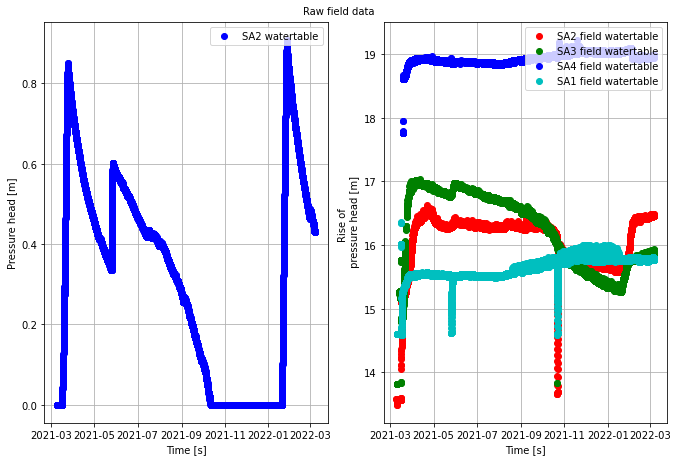

In [10]:
# plot multiple graph to show changes of the results

# run get_ipython().run_line_magic('matplotlib', 'auto') to allow the graph pop out for each zoom in and out
fig, axes = plt.subplots(
    ncols = 2,
    nrows = 1,
    sharex= False,
    figsize = (9.3, 6.3),
    constrained_layout=True,
)

fig.suptitle('Raw field data',fontsize=10)
ax = axes[0]

ax.plot(field.pond_depth_sa2_df.index ,
         field.pond_depth_sa2_df['value'],
         'bo',
         label="SA2 watertable")

ax.set_xlabel('Time [s]')
ax.set_ylabel('Pressure head [m]')
ax.grid()
ax.legend(loc="upper right",fontsize=10)

#
ax = axes[1]
ax.plot(field.watertable_sa2_df.index , 
        field.watertable_sa2_df['value'],
        'ro',
        label="SA2 field watertable")
ax.plot(field.watertable_sa3_df.index , 
        field.watertable_sa3_df['value'],
        'go',
        label="SA3 field watertable")
ax.plot(field.watertable_sa4_df.index , 
        field.watertable_sa4_df['value'],
        'bo',
        label="SA4 field watertable")
ax.plot(field.watertable_sa1_df.index , 
        field.watertable_sa1_df['value'],
        'co',
        label="SA1 field watertable")
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Rise of \n pressure head [m]')
ax.legend(loc="upper right",fontsize=10)


In [11]:
# process the data 
# get rid of the drop and rise of water table due to a pumping event
time_start_dt64 = np.datetime64('2021-05-25T13:00')
time_end_dt64   = np.datetime64('2021-06-01T17:00')
#mask_pumping_event= field.watertable_sa2_df[time_start_dt64:time_end_dt64]
field.watertable_sa1_df[time_start_dt64:time_end_dt64] = np.nan
field.watertable_sa2_df[time_start_dt64:time_end_dt64] = np.nan
field.watertable_sa3_df[time_start_dt64:time_end_dt64] = np.nan

time_start_dt64 = np.datetime64('2021-10-21T13:00')
time_end_dt64   = np.datetime64('2021-10-24T17:00')
#mask_pumping_event= field.watertable_sa2_df[time_start_dt64:time_end_dt64]
field.watertable_sa1_df[time_start_dt64:time_end_dt64] = np.nan
field.watertable_sa2_df[time_start_dt64:time_end_dt64] = np.nan
field.watertable_sa3_df[time_start_dt64:time_end_dt64] = np.nan


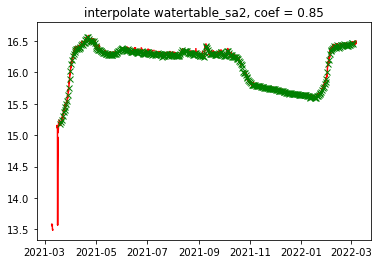

In [12]:
field.sim_time_array_dt64 = field.simlation_start_time_dt64 + \
                np.array(gwf.modeltime.totim, dtype='timedelta64[D]')
field.merged_df = pd.DataFrame(index=field.sim_time_array_dt64)
field.merged_df['time_elapsed_days'] = (field.merged_df.index - \
                field.simlation_start_time_dt64) /np.timedelta64(1, 'D')


csaps_coef = 0.85
mask = field.watertable_sa2_df['value'].isnull()
# i can not find a coefficient that works well with index.
# field.merged_df['surface_depth_sa2_m'] = csaps(field.watertable_sa2_df.index[~mask], 
#            field.watertable_sa2_df['value'][~mask],
#            field.merged_df.index, 
#            smooth = csaps_coef)

field.merged_df['watertable_sa2_m'] = \
           csaps(field.watertable_sa2_df['time_elapsed_days'][~mask], 
           field.watertable_sa2_df['value'][~mask],
           field.merged_df['time_elapsed_days'], 
           smooth = csaps_coef)
# plot interpolation
fig=plt.figure()
ax  = fig.add_subplot(1, 1, 1)
ax.plot(field.watertable_sa2_df.index,
        field.watertable_sa2_df['value'],
        'r-',
        label='watertable_sa2_original')
ax.plot( field.merged_df.index,
         field.merged_df['watertable_sa2_m'],
         'gx',
        label='watertable_sa2_fitted')
ax.set_title('interpolate watertable_sa2, coef = ' 
             + str(csaps_coef) )
field.merged_df['watertable_rise_sa2_m'] = \
            field.merged_df['watertable_sa2_m'] - \
            field.merged_df['watertable_sa2_m'] [0]

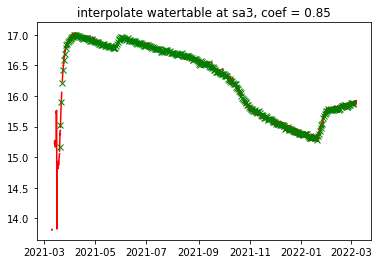

In [13]:
# csaps does not like NaNs, so NaN is masked before interpolation 
mask = field.watertable_sa3_df['value'].isnull()
field.merged_df['watertable_sa3_m'] = csaps(field.watertable_sa3_df['time_elapsed_days'][~mask], 
           field.watertable_sa3_df['value'][~mask],
           field.merged_df['time_elapsed_days'], 
           smooth = csaps_coef)
# plot interpolation
fig=plt.figure()
ax  = fig.add_subplot(1, 1, 1)
ax.plot(field.watertable_sa3_df.index,
        field.watertable_sa3_df['value'],
        'r-',
        label='watertable_sa3_original')
ax.plot( field.merged_df.index,
         field.merged_df['watertable_sa3_m'],
         'gx',
        label='watertable_sa3_fitted')
ax.set_title('interpolate watertable at sa3, coef = ' 
             + str(csaps_coef) )
field.merged_df['watertable_rise_sa3_m'] = \
            field.merged_df['watertable_sa3_m'] - \
            field.merged_df['watertable_sa3_m'] [0]

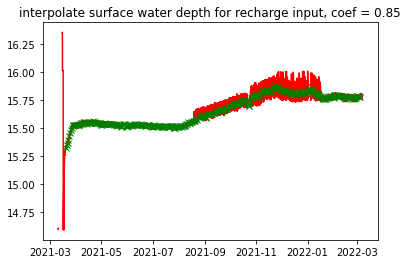

In [14]:
# csaps does not like NaNs, so NaN is masked before interpolation 
mask = field.watertable_sa1_df['value'].isnull()
field.merged_df['watertable_sa1_m'] = csaps(
           field.watertable_sa1_df['time_elapsed_days'][~mask], 
           field.watertable_sa1_df['value'][~mask],
           field.merged_df['time_elapsed_days'], 
           smooth = csaps_coef)
# plot interpolation
fig=plt.figure()
ax  = fig.add_subplot(1, 1, 1)
ax.plot(field.watertable_sa1_df.index,
        field.watertable_sa1_df['value'],
        'r-',
        label='watertable_sa1_original')
ax.plot( field.merged_df.index,
         field.merged_df['watertable_sa1_m'],
         'gx',
        label='watertable_sa1_fitted')
ax.set_title('interpolate surface water depth for recharge input, coef = ' 
             + str(csaps_coef) )
field.merged_df['watertable_rise_sa1_m'] = \
                field.merged_df['watertable_sa1_m'] \
                -field.merged_df['watertable_sa1_m'] [0]

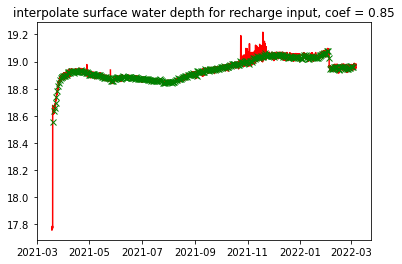

In [15]:
# csaps does not like NaNs, so NaN is masked before interpolation 
mask = field.watertable_sa4_df['value'].isnull()
field.merged_df['watertable_sa4_m'] = csaps(
           field.watertable_sa4_df['time_elapsed_days'][~mask], 
           field.watertable_sa4_df['value'][~mask],
           field.merged_df['time_elapsed_days'], 
           smooth = csaps_coef)
# plot interpolation
fig=plt.figure()
ax  = fig.add_subplot(1, 1, 1)
ax.plot(field.watertable_sa4_df.index,
        field.watertable_sa4_df['value'],
        'r-',
        label='watertable_sa4_original')
ax.plot( field.merged_df.index,
         field.merged_df['watertable_sa4_m'],
         'gx',
        label='watertable_sa4_fitted')
ax.set_title('interpolate surface water depth for recharge input, coef = ' 
             + str(csaps_coef) )
field.merged_df['watertable_rise_sa4_m'] = \
                field.merged_df['watertable_sa4_m'] \
                -field.merged_df['watertable_sa4_m'] [0]

Text(0.5, 1.0, 'interpolate surface water depth for recharge input, coef = 0.85')

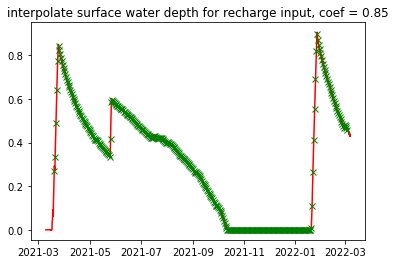

In [16]:
# csaps does not like NaNs, so NaN is masked before interpolation 
mask = field.pond_depth_sa2_df['value'].isnull()
field.merged_df['pond_depth_sa2_m'] = csaps(
           field.pond_depth_sa2_df['time_elapsed_days'][~mask], 
           field.pond_depth_sa2_df['value'][~mask],
           field.merged_df['time_elapsed_days'], 
           smooth = csaps_coef)
# plot interpolation
fig=plt.figure()
ax  = fig.add_subplot(1, 1, 1)
ax.plot(field.pond_depth_sa2_df.index,
        field.pond_depth_sa2_df['value'],
        'r-',
        label='pond_depth_sa2')
ax.plot( field.merged_df.index,
         field.merged_df['pond_depth_sa2_m'],
         'gx',
        label='watertable_sa2_fitted')
ax.set_title('interpolate surface water depth for recharge input, coef = ' 
             + str(csaps_coef) )

In [17]:
# dis package
idomain = np.full((nlay, nrow, ncol), 1) # similar to idomain where 0 means inactive cell, 1 means active cell
dis = flopy.mf6.ModflowGwfdis(gwf, 
                              nlay = nlay, 
                              nrow = nrow, 
                              ncol = ncol,
                              delr = delr_m, 
                              delc = delc_m,
                              top  = ztop_m, 
                              botm = vertices_elev_layer_l_list_m[1:], 
                              idomain=1   # temperorily presscribed
                              )
# # https://github.com/modflowpy/flopy/blob/5fcf9709ec8a655106c57d55657c47b1d4987812/examples/Notebooks/flopy3_gridgen.ipynb



In [18]:
# use of gridgen 
#https://github.com/modflowpy/flopy/blob/5fcf9709ec8a655106c57d55657c47b1d4987812/examples/Notebooks/flopy3_gridgen.ipynb
# setup the active domain
from flopy.utils.gridgen import Gridgen 
# Check and make sure the data folder exists.

if not os.path.exists(model_ws):
    os.makedirs(model_ws)
gridgen_ws = os.path.join(model_ws, 'gridgen')
if not os.path.exists(gridgen_ws):
    os.makedirs(gridgen_ws)
print('Model workspace is : {}'.format(model_ws))
print('Gridgen workspace is : {}'.format(gridgen_ws))



Model workspace is : .\data
Gridgen workspace is : .\data\gridgen


In [19]:
#  define a circle in the middle

adpoly_rch =dotdict({'centre_xy_ay_m'  : (Lx_m/2.0,Ly_m/2.0) ,
                      'radius_m' : 100. , 
                      'circle_perimeter_xy_ay': [[[]]]
                      })

adpoly_rch.number_points_perimeter =30

for i in np.arange(0., 2.*np.pi, np.pi/adpoly_rch.number_points_perimeter):
    adpoly_rch.circle_perimeter_xy_ay[0][0].append((adpoly_rch.centre_xy_ay_m[0] + 
                                      adpoly_rch.radius_m * np.cos(i),
                                      adpoly_rch.centre_xy_ay_m[1] + 
                                      adpoly_rch.radius_m * np.sin(i)
                                      ))
# the below line is needed as the fist and final point needs 
# to be exactly (meaning 5~=4.999999999) the same.
adpoly_rch.circle_perimeter_xy_ay[0][0].append(adpoly_rch.circle_perimeter_xy_ay[0][0][0])

g = Gridgen(dis, model_ws=gridgen_ws)
g.build()

adshp = os.path.join(gridgen_ws, 'ad0')

adline_chd = dotdict({'xy_list_m':[[[(0,0),(Lx_m,0),(Lx_m,Ly_m),(0,Ly_m),(0,0)]]]})
adline_chd.gridgen_intersect = g.intersect(adline_chd.xy_list_m,
                               'line',
                               0)
# g.add_active_domain(adpoly_lake, range(nlay))
# the number at the third argument refers to the layers.
adpoly_rch.gridgen_intersect = g.intersect(adpoly_rch.circle_perimeter_xy_ay, 
                                    'polygon', 
                                    0)  

point_SA3 = dotdict({'x_m':240.1,'y_m':150.1})
point_SA3.gridgen_intersect = g.intersect([(point_SA3.x_m,point_SA3.y_m)],
                         "point",
                         0)
point_SA3.lrc_loc = gwf.modelgrid.get_lrc(point_SA3.gridgen_intersect.nodenumber[0])[0]
point_SA3.surface_area_cell_m2 = g.get_area()[point_SA3.gridgen_intersect.nodenumber[0]]


point_SA2 = dotdict({'x_m':150.1,'y_m':150.1})
point_SA2.gridgen_intersect = g.intersect([(point_SA2.x_m,point_SA2.y_m)] ,
                         "point",
                         0)
point_SA2.lrc_loc = gwf.modelgrid.get_lrc(point_SA2.gridgen_intersect.nodenumber[0])[0]
point_SA2.surface_area_cell_m2 = g.get_area()[point_SA2.gridgen_intersect.nodenumber[0]]


point_SA4 = dotdict({'x_m':280.1,'y_m':150.1})
point_SA4.gridgen_intersect = g.intersect([(point_SA4.x_m,point_SA4.y_m)] ,
                         "point",
                         0)
point_SA4.lrc_loc = gwf.modelgrid.get_lrc(point_SA4.gridgen_intersect.nodenumber[0])[0]
point_SA4.surface_area_cell_m2 = g.get_area()[point_SA4.gridgen_intersect.nodenumber[0]]

#  flopy.utils.gridintersect.gridintersect.intersects works well for points
point_intersect =  g.intersect([[[(150.1,150.1)]]],
                                'point',
                                0)

#adpoly_rch.gridgen_intersect = g.intersect(adpoly_rch.circle_perimeter_xy_ay, 'polygon', 1)
print(adpoly_rch.gridgen_intersect.dtype.names)
print(adpoly_rch.gridgen_intersect)
print(adpoly_rch.gridgen_intersect.nodenumber)
print(adline_chd.gridgen_intersect.nodenumber)

idomain_1d_list = np.zeros((ncol*nrow), dtype=int) + 3  # active cell
rf2shp = os.path.join(gridgen_ws, 'rf0')

('nodenumber', 'polyid', 'totalarea', 'SHAPEID')
[(113, 0, 225.    , 0) ( 89, 0, 225.    , 0) ( 90, 0, 225.    , 0)
 (112, 0, 225.    , 0) ( 91, 0, 225.    , 0) ( 88, 0, 225.    , 0)
 (106, 0, 225.    , 0) (107, 0, 225.    , 0) (125, 0, 225.    , 0)
 (134, 0, 225.    , 0) (145, 0, 225.    , 0) (164, 0, 225.    , 0)
 (195, 0, 225.    , 0) (184, 0, 225.    , 0) (175, 0, 225.    , 0)
 (154, 0, 225.    , 0) (235, 0, 225.    , 0) (224, 0, 225.    , 0)
 (245, 0, 225.    , 0) (204, 0, 225.    , 0) (215, 0, 225.    , 0)
 (287, 0, 225.    , 0) (308, 0, 225.    , 0) (274, 0, 225.    , 0)
 (293, 0, 225.    , 0) (286, 0, 225.    , 0) (265, 0, 225.    , 0)
 (254, 0, 225.    , 0) (292, 0, 225.    , 0) (311, 0, 225.    , 0)
 (310, 0, 225.    , 0) (309, 0, 225.    , 0) (133, 0, 225.    , 0)
 (109, 0, 225.    , 0) (110, 0, 225.    , 0) (132, 0, 225.    , 0)
 (111, 0, 225.    , 0) (108, 0, 225.    , 0) (126, 0, 225.    , 0)
 (127, 0, 225.    , 0) (146, 0, 225.    , 0) (165, 0, 225.    , 0)
 (194, 0, 225

In [20]:
#  plot idomain
#a[adpoly_rch.gridgen_intersect.nodenumber] = 2
idomain_rch = 2  # all the idomains that will be subjected to recharge will be tagged with 2.
idomain_constant_head = 5 # chd
idomain_1d_list[adpoly_rch.gridgen_intersect.nodenumber] = idomain_rch
idomain_1d_list[adline_chd.gridgen_intersect.nodenumber]  = idomain_constant_head
idomain_lrc_list = idomain_1d_list.reshape(nlay,nrow,ncol)
dis.idomain = idomain_lrc_list

In [21]:
# 
# interesting to find that the it is better to be converged, 
# when the head is above zero 
strt_m = params['strt_m']
strt_lrc_list_m = strt_m * \
    np.ones((nlay, nrow, ncol), dtype=np.float32)   # initial hydraulic head
    
ic = flopy.mf6.ModflowGwfic(gwf, 
                            strt = strt_lrc_list_m)

In [22]:
# #k33 ([double]) –
#k33 (double) is the hydraulic conductivity of the third ellipsoid axis (or the ratio of K33/K if the
# K33OVERK option is specified); for an unrotated case, this is the vertical hydraulic conductivity.
# When anisotropy is applied, K33 corresponds to the K33 tensor component. All included cells (IDOMAIN > 0) must have a K33 value greater than zero.
# icelltype (integer) flag for each cell that specifies how saturated thickness is treated. 0 means saturated thickness is held constant; 
#:math:`>`0 means saturated thickness varies with computed head when head is below the cell top; 
#:math:`<`0 means saturated thickness varies with computed head unless the THICKSTRT option is in effect. 
# When THICKSTRT is in effect, a negative value of icelltype indicates that saturated thickness will be computed as STRT-BOT and held constant.
# k22 is equal to k by default
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              xt3doptions = False,
                              save_flows = True,
                              save_specific_discharge = True,
                              icelltype = 1,   # meaning that transmissivity changes with heads
                              k   = kh_lrc_list, 
                              k33 = vka_lrc_list)
# iconvert (integer) is a flag for each cell that specifies 
# whether or not a cell is convertible for the storage 
# calculation. 0 indicates confined storage is used. 
# :math:`>`0 indicates confined storage is used when head is 
# above cell top and a mixed formulation of unconfined and 
# confined storage is used when head is below cell top.
sto = flopy.mf6.ModflowGwfsto(gwf, 
                              sy = sy, 
                              ss = ss, 
                              iconvert = 1
                              )
# # https://modflowpy.github.io/flopydoc/mflpf.html

In [23]:
#
# CZ220303 removed 'steps' to make it work
oc = flopy.mf6.ModflowGwfoc(gwf,
                   budget_filerecord ='{}.cbc'.format(fModName),
                   head_filerecord   ='{}.hds'.format(fModName),
                   headprintrecord   =[
                                ('COLUMNS', 10, 'WIDTH', 15,
                                 'DIGITS', 6, 'GENERAL')],
                   saverecord=[('HEAD', 'ALL'),
                               ('BUDGET', 'ALL')],
                   printrecord=[('HEAD', 'LAST'),
                                ('BUDGET', 'LAST')])




In [24]:
# constant head package
chd_spd = []

boundary_constant_head_m = strt_m
for i in list(set(adline_chd.gridgen_intersect.nodenumber)):
    coord= gwf.modelgrid.get_lrc(i)
    chd_spd.append(  [ (0 , coord[0][1], coord[0][2]) , 
                      boundary_constant_head_m  ] )

chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data={0: chd_spd,1: chd_spd},
)
    


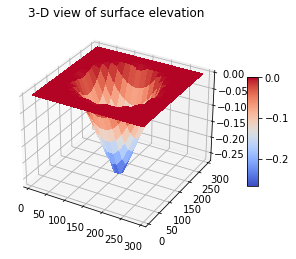

In [25]:
# installing wells 
# Note: the row starts from top to bottom, so the first row has 
# a coordinate of 300, the last row has a corrdinate of 0

pond_bed_slope_tan = 0.003  # np.tan(.5*np.pi/180) np.arctan(0.003)/np.pi*180

dist_to_pond_centre_cell_rc_ay_m = (( gwf.modelgrid.xcellcenters - point_SA2.x_m ) ** 2. + \
                                   ( gwf.modelgrid.ycellcenters - point_SA2.y_m ) ** 2. ) \
                                   ** 0.5

max_depth_m = adpoly_rch.radius_m * pond_bed_slope_tan

depth_cell_rc_ay_m = max_depth_m - dist_to_pond_centre_cell_rc_ay_m * pond_bed_slope_tan

depth_cell_rc_ay_m [depth_cell_rc_ay_m <  0] =0

surface_elevation_cell_rc_ay_m = ztop_m - depth_cell_rc_ay_m



from matplotlib import cm
#get_ipython().run_line_magic('matplotlib', 'auto')  #allow the graph to pop out
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_title('3-D view of surface elevation')
# plot a 3D surface like in the example mplot3d/surface3d_demo
surf = ax.plot_surface(gwf.modelgrid.xcellcenters, 
                       gwf.modelgrid.ycellcenters, 
                       surface_elevation_cell_rc_ay_m,
                       rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=10)
dis.top = surface_elevation_cell_rc_ay_m


In [26]:
# rch package recharge package

# https://stackoverflow.com/questions/7961363/removing-duplicates-in-lists
# list(set(t))
# duplicate nodes exists in the intersect nodenumber, 
# which needs to be removed

# # METHOD 1: a constant recharge is applied throughout the domain
# rch_spd_dict = {}
# recharge_rate_spd_ay = np.zeros(nper,dtype=float)
# # during the first 100 days, the recharge rate is 0.1 m/day
# recharge_rate_spd_ay [ stress_period_end_time_days_ay <= 100 ] \
#     = 0.1
# for per in np.arange(nper):
#     rch_spd = []
#     for i in list(set(adpoly_rch.gridgen_intersect.nodenumber)) :
#         coord= gwf.modelgrid.get_lrc(i)
#         rch_spd.append([0, 
#                         coord[0][1], 
#                         coord[0][2], 
#                         recharge_rate_spd_ay[per]] )
#     rch_spd_dict[per] =  rch_spd


# METHOD 2 RECHARGE BASED ON THE SURFACE WATER DEPTH
# this method assumes the hydraulic conductivity across the unsat
# zone is constant, the rise of water table due to recharge does 
# not affect significantly the thickness of the unsat zone.

# list of variables used for calculating recharge at each cells
# surface_water_depth_rch_input_totim_ay_m
# gwf.modeltime.totim
# gwf.modelgrid.xcellcenters
# gwf.modelgrid.ycellcenters
# surface_elevation_cell_rc_ay_m
# point_SA2.xy or .x .y
# point_SA2.lrc_loc


rch_spd_dict = {}
point_SA2.surface_elevation_m = surface_elevation_cell_rc_ay_m[  point_SA2.lrc_loc[1], point_SA2.lrc_loc[2]]

depth_unsat_zone_m  = 5.0
kz_clay_mPday= params['kz_clay_mPday']
#kz_clay_mPday =  0.00864 #* 5  # 1e-14 * 5 * 9800000 * 86400 # crazy result

#kz_clay_mPday =  0.00864 * 5 # best result
adpoly_rch.gridgen_intersect.nodenumber_nonreapeating = list(set(adpoly_rch.gridgen_intersect.nodenumber))

for per in np.arange(nper):
    rch_spd = []
    for i in  adpoly_rch.gridgen_intersect.nodenumber_nonreapeating :
        lrc_lake_point = gwf.modelgrid.get_lrc(i)
        surface_elevation_lake_point_m = surface_elevation_cell_rc_ay_m[  lrc_lake_point[0][1], lrc_lake_point[0][2] ]
        delta_z_m = surface_elevation_lake_point_m - point_SA2.surface_elevation_m   # tends to be a positive value as lake centre is a rather low point.
        #water_depth_lake_point_m = surface_water_depth_rch_input_totim_ay_m[per] - delta_z_m
        water_depth_lake_point_m = field.merged_df['pond_depth_sa2_m'][per]- delta_z_m
        if water_depth_lake_point_m < 0.01 : 
            recharge_rate_mPday = 0
        else:
            recharge_rate_mPday = kz_clay_mPday * \
                (depth_unsat_zone_m + water_depth_lake_point_m) / depth_unsat_zone_m

        rch_spd.append([0, 
                        lrc_lake_point[0][1], 
                        lrc_lake_point[0][2], 
                        recharge_rate_mPday
                        ])
    rch_spd_dict[per] =  rch_spd


# https://github.com/MODFLOW-USGS/modflow6-examples/blob/7de506bb5fdaf4052a0cc33675bbb54457f20d61/scripts/ex-gwf-advtidal.py
# an example to output recharge to a file.
rch = flopy.mf6.ModflowGwfrch(
    gwf, 
    stress_period_data = rch_spd_dict,
    pname='rch',   #"RCH-ZONE_{}".format(5),
)


# # plot to check the result of the recharge
# fig = plt.figure(figsize=(12, 9))
# ax  = fig.add_subplot(1, 1, 1, aspect="equal")

# a = [ rch_spd_dict[i][0][9][10] for i in np.arange(nper) ]

# for rch_spd_dict the indexes are [stresperiod][ index in adpoly_rch.gridgen_intersect.nodenumber_nonreapeating ][1-layer, 2-row, 3- column 4-rechargerate]



In [27]:
# create observation package
obs = flopy.mf6.ModflowUtlobs(
    model  = gwf , # groundwater flow package to be used
    digits = 10, # default digits to print out
    print_input = True, 
    continuous= {'{}.obs.csv'.format(fModName):
                 [['head_SA2', 'HEAD', point_SA2.lrc_loc],
                  ['head_SA3', 'HEAD', point_SA3.lrc_loc ],
                  ['head_SA4', 'HEAD', point_SA4.lrc_loc ],
                  ],
                 
                 },
    pname = 'obs',
    filename='{}.obs'.format(fModName)
    )

# https://github.com/langevin-usgs/gw3099_classrepo/blob/d965f76fe707ad1178e0aef8c4d2db6c17538ef1/exercises/MODFLOW6/ex06-completed.ipynb
# CZ220315 tried to run thiswrong message occured.

# https://github.com/langevin-usgs/mf6flopy2019_classrepo/blob/a92ab4334eb7e63b8834e0dce3b968113f32af06/exercises/MODFLOW6/ex08-completed.ipynb
# CZ220315 it is a beautiful example and i should follow
# lak.obs.initialize(filename=lakobsname, continuous={'ex07.lak.obs.csv': lak_obs})

fname_rch_obs_out = '{}.rch.obs.csv'.format(fModName)
rch.obs.initialize(filename= '{}.rch.obs'.format(fModName) ,
                   digits = 7,
                   continuous= {fname_rch_obs_out: 
                                [['rch_SA2', 'RCH', point_SA2.lrc_loc],
                                 ['rch_SA3', 'RCH', point_SA3.lrc_loc ]
                                 ]} ,
                   )
# rch_o = gwf.get_package('RCH')
# rch_o.stress_period_data.get_data(key=0)



# rch_obs = flopy.mf6.ModflowUtlobs(
#     model  = gwf , # groundwater flow package to be used
#     parent_file = rch ,
#     continuous= {'aa_out':['rch_SA2', 'RCH', point_SA2.lrc_loc ] } ,
#     filename = 'obs_2.obs',
#     pname = 'obs_2'
# )


# add river observations
# rivobsname = 'ex06.riv.obs'
# riv.obs_filerecord.set_data([rivobsname])
# riv_obs = [('RIVER-1', 'RIV', 'seg1'), ('RIVER-2', 'RIV', 'seg2'), 
#            ('RIVER-3', 'RIV', 'seg3'), ('RIVER-4', 'RIV', 'seg4')]
# rivobs = flopy.mf6.ModflowUtlobs(gwf, continuous={'ex06.riv.obs.csv': riv_obs}, parent_file=riv, fname=rivobsname)


# find the cell which is intersected by the well

#wel_loc = (2, wel_id['cellids'][0][0], wel_id['cellids'][0][1])
#wel_spd = {1:[2, wel_id['cellids'][0][0], wel_id['cellids'][0][1], dch_wel, 0, 'dch_well']} # ordered dictionary to specify data for stress period 1

# wel = flopy.mf6.ModflowGwfwel(
#     gwf,
#     stress_period_data=wel_spd,
#     pname = 'wel'
# )

#np.ma.masked_equal(dis.sr.ygrid,1000) # very useful command to find specific file locations
#modelmap.sr.vertices
#flopy.plot.plotutil.cell_value_points
#
#
#modeLx_msect = flopy.plot.Modelc_mrossSection(model=mf, line={'Row': 0})



# oc = flopy.modflow.ModflowOc(mf, 
#                              stress_period_data=stress_period_data,
#                              compact=True)
# recharge package
#recharge_rate_mPday = {"0":0.1,"1":0.1}   #0.1 #0.01

# nrchop (int) – is the recharge option code. 
# 1: Recharge to top grid layer only 
# 2: Recharge to layer defined in irch 
# 3: Recharge to highest active cell (default is 3).
#nrchop = 1



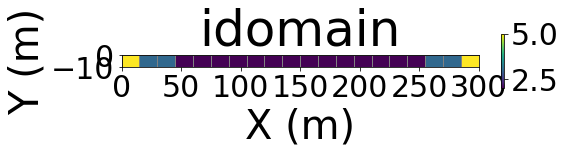

In [28]:
# plot grid and idomain to show results plot the vertical view of the model
fig = plt.figure(figsize=(8, 5))
ax  = fig.add_subplot(1, 1, 1, aspect="equal")
modeLx_msect = flopy.plot.PlotCrossSection(model=gwf, line={'Row': 10})
arr = modeLx_msect.plot_array(dis.idomain[0,:,:])
modeLx_msect.plot_grid()
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#obs_ = mm.plot_bc("OBS")
ax.set_xlabel('X (m)', fontsize=40)
ax.set_ylabel('Y (m)', fontsize=40)
ax.set_title('idomain', fontsize=50)
#ax.colorbar(shrink=0.5, ax=ax)
#plt.colorbar(cax=ax)
cbar=plt.colorbar(arr, shrink=0.2, ax=ax)
cbar.ax.tick_params(labelsize=30)

Text(0.5, 1.0, 'IDOMAIN')

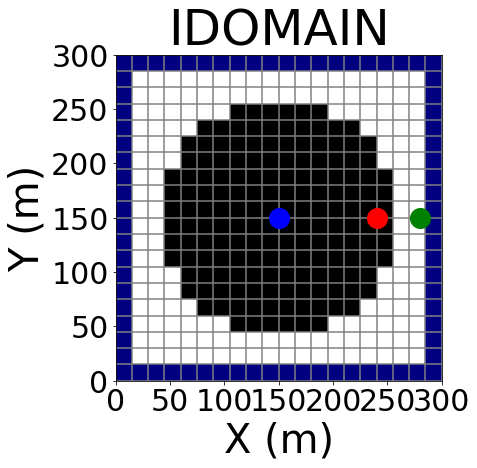

In [29]:
#
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
#arr=g.plot(ax, a=dis.idomain, masked_values=[0], edgecolor='none', cmap='jet')
mm = flopy.plot.PlotMapView(model=gwf)
#mm.plot_ibound()
#flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='yellow', alpha=0.25)
rch_ = mm.plot_bc("RCH")
chd_ = mm.plot_bc("CHD")
#obs_ = mm.plot_bc("OBS")
plt.plot(point_SA3.x_m,point_SA3.y_m,'ro',markersize=20)
plt.plot(point_SA2.x_m,point_SA2.y_m,'bo',markersize=20)
plt.plot(point_SA4.x_m,point_SA4.y_m,'go',markersize=20)
mm.plot_grid()
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_xlabel('X (m)', fontsize=40)
ax.set_ylabel('Y (m)', fontsize=40)
ax.set_title('IDOMAIN', fontsize=50)

In [30]:
#
sim.write_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model FlowModel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 76 based on size of stress_period_data
    writing package rch...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 164 based on size of stress_period_data
    writing package obs...
    writing package obs_0...


In [31]:
try:
    os.remove(os.path.join(model_ws, "{0}.hds".format(modelname)))
except:
    pass
success,mfoutput = sim.run_simulation(silent=False, pause=False,report=True) #mfoutput = mf.run_model(silent=True, pause=False, report=True)
if not success:
        raise Exception('MODFLOW did not terminate normalLy_m.')

FloPy is using the following executable to run the model: C:\MinGW\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Jul 30 2021 14:34:58 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources S

In [32]:
#import flopy.utils.binaryfile as bf
# Create the headfile and budget file objects
headobj       = flopy.utils.HeadFile(os.path.join(ws,fModName+'.hds'))
times_headobj = headobj.get_times()
cbcobj = flopy.utils.CellBudgetFile(os.path.join(ws,fModName+'.cbc'))
times_cbcobj = cbcobj.get_times()
#tsList = budObj.get_kstpkper() work but not needed.

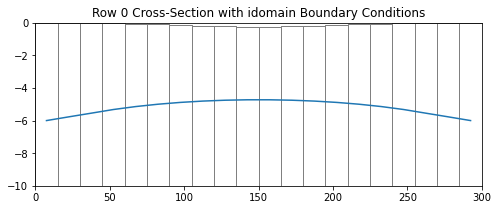

In [33]:
# a list of times where the head distribution over time will be plotted.
times_output_list_day = [11.5, 101.0, 150, 200]
# find out the index of the head output (totim)
# that is cloest to the listed time for 
# plotting.  
index_of_totim_output_list_day = \
    [( abs(i-gwf.modeltime.totim) ).argmin() for i in times_output_list_day]
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
#modeLx_msect = flopy.plot.Modelc_mrossSection(model=mf, line={'Column': 5})  
# this will onLy_m work when nrow is more than 1
##CM modeLx_msect = flopy.plot.Modelc_mrossSection(model=mf, line={'Row': 0})
modeLx_msect   = flopy.plot.PlotCrossSection(model=gwf, line={'Row': int(nrow/2) })
patches        = modeLx_msect.plot_ibound()
linecollection = modeLx_msect.plot_grid()
t = ax.set_title('Row 0 Cross-Section with idomain Boundary Conditions')
head = headobj.get_data(totim=times_output_list_day[1])
ax.plot(gwf.modelgrid.xycenters[0],head[-1,int(nrow/2),:])   
# head = headobj.get_data(totim=times_output_list_day[1])
# head[head==1e-30] = np.nan

Text(0, 0.5, 'Z (m)')

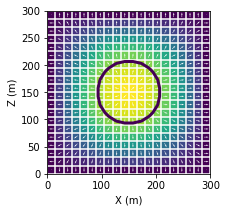

In [34]:
fig = plt.figure(figsize=(8, 3))
ax  = fig.add_subplot(1, 1, 1)
# t   = ax.set_title('Head distribution at the end of stress period 1, day %i' %(times_output_list_day[0]))
# head = headobj.get_data(totim=times_output_list_day[0])
# modeLx_msect = flopy.plot.PlotCrossSection(model=gwf, line={'Row': 0})
# arr = modeLx_msect.plot_array(head)
# grd = modeLx_msect.plot_grid()
# ax.plot(gwf.modelgrid.xycenters[0] , head[-1,0,:], linewidth=5.0)
# plt.colorbar(arr, shrink=1, ax=ax)
times_head_ay_days = gwf.output.head().get_times()
head = gwf.output.head().get_data(totim = times_head_ay_days[-1])
times_bud_ay = gwf.output.head().get_times
bud = gwf.output.budget()

#
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
pmv.plot_grid(colors='white')
pmv.plot_vector(qx, qy, normalize=True, color="white")
pmv.contour_array(head, levels=[-5,-4,-3,-2], linewidths=3.)
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')

Text(0, 0.5, 'Z (m)')

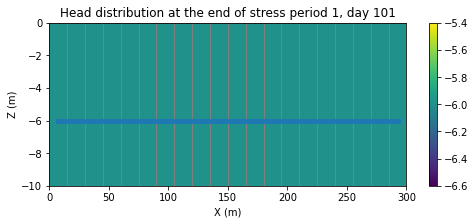

In [35]:
fig = plt.figure(figsize=(8, 3))
ax  = fig.add_subplot(1, 1, 1)
t   = ax.set_title('Head distribution at the end of stress period 1, day %i' %(times_output_list_day[1]))
head = headobj.get_data(totim=times_output_list_day[1])
modeLx_msect = flopy.plot.PlotCrossSection(model=gwf, line={'Row': 0})
arr = modeLx_msect.plot_array(head)
grd = modeLx_msect.plot_grid()
ax.plot(gwf.modelgrid.xycenters[0] , head[-1,0,:], linewidth=5.0)
plt.colorbar(arr, shrink=1, ax=ax)
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')

In [36]:
# this may be replaced by pandas
time_array_obs_output_day, \
    hydrualic_head_SA2_time_array_m, \
    hydrualic_head_SA3_time_array_m, \
    hydrualic_head_SA4_time_array_m = \
    np.genfromtxt(os.path.join(ws,'{}.obs.csv'.format(fModName)), 
    skip_header=1, 
    delimiter=',').T

#
time_array_rch_obs_output_day, \
    recharge_SA2_time_array_m3Pday, \
    recharge_SA3_time_array_m3Pday = \
    np.genfromtxt(os.path.join(ws,fname_rch_obs_out), 
    skip_header=1, 
    delimiter=',').T

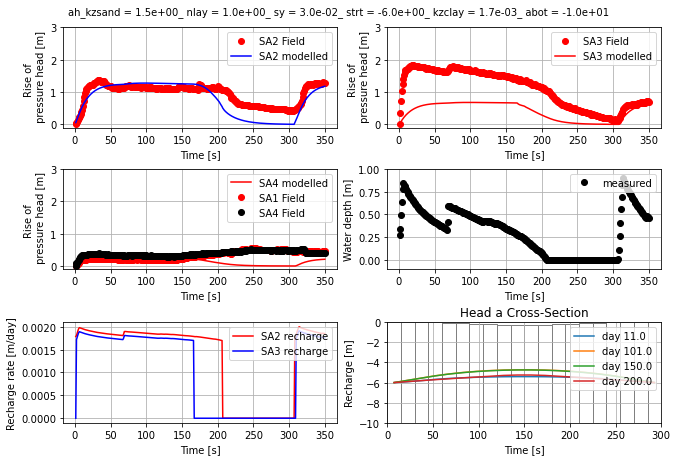

ah_kzsand_1.5e00_nlay_1.0e00_sy_3.0ne02_strt_-6.0e00_kzclay_1.7ne03_abot_-1.0e01


In [37]:
# plot multiple graph to show changes of the results
fig, axes = plt.subplots(
    ncols = 2,
    nrows = 3,
    sharex= False,
    figsize = (9.3, 6.3),
    constrained_layout=True,
)

title_str =params['caseid'] + \
    '_kzsand = {:1.1e}'.format(kh_sand_mPday) + \
    '_ nlay = {:1.1e}'.format(nlay) \
    +'_ sy = {:1.1e}'.format(sy) + \
    '_ strt = {:1.1e}'.format(strt_m) \
    + '_ kzclay = {:1.1e}'.format(kz_clay_mPday) + \
    '_ abot = {:1.1e}'.format(zbot_m)

#    
fig.suptitle(title_str,fontsize=10)
ax = axes[0,0]
# ax.plot(field_data_df['time_elapsed_days'],
#          field_data_df['sa2_watertable_rise_mm'] * mPmm,
#          'bo',
#          markevery=1000,
#          label="SA2 Field")
ax.plot(field.merged_df['time_elapsed_days'],
        field.merged_df['watertable_rise_sa2_m'],
        'ro',
        #markevery=1000,
        label="SA2 Field")
ax.plot(time_array_obs_output_day,
        hydrualic_head_SA2_time_array_m - strt_m,
        'b-',
        label='SA2 modelled')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Rise of \n pressure head [m]')
ax.grid()
ax.set_ylim(-0.1,3)
ax.legend(loc="upper right",fontsize=10)

#
ax = axes[0,1]
# ax.plot(field_data_df['time_elapsed_days'],
#         field_data_df['sa3_watertable_rise_mm'] * mPmm,
#         'go',
#         markevery=1000,
#         label="SA3 Field")
ax.plot(field.merged_df['time_elapsed_days'],
        field.merged_df['watertable_rise_sa3_m'],
        'ro',
        #markevery=1000,
        label="SA3 Field")

ax.plot(time_array_obs_output_day,
        hydrualic_head_SA3_time_array_m - strt_m,
        'r-',
        label='SA3 modelled')
ax.grid()
ax.set_ylim(-0.1,3)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Rise of \n pressure head [m]')
ax.legend(loc="upper right",fontsize=10)

ax = axes[1,0]
ax.plot(time_array_obs_output_day,
        hydrualic_head_SA4_time_array_m - strt_m,
        'r-',
        label='SA4 modelled')
# ax.plot(field_data_df['time_elapsed_days'],
#         field_data_df['sa1_watertable_rise_mm'] * mPmm,
#         'bo',
#         markevery=1000,
#         label="SA4 Field")
ax.plot(field.merged_df['time_elapsed_days'],
        field.merged_df['watertable_rise_sa1_m'],
        'ro',
        #markevery=1000,
        label="SA1 Field")

ax.plot(field.merged_df['time_elapsed_days'],
        field.merged_df['watertable_rise_sa4_m'],
        'ko',
        #markevery=1000,
        label="SA4 Field")
ax.grid()
ax.set_ylim(-0.1,3)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Rise of \n pressure head [m]')
ax.legend(loc="upper right",fontsize=10)

ax = axes[1,1]
# ax.plot(field_data_df['time_elapsed_days'],
#         field_data_df['surface_water_depth_m'],
#         'ko',
#         markevery=1000,
#         label="measured")
ax.plot(field.merged_df['time_elapsed_days'],
        field.merged_df['pond_depth_sa2_m'],
        'ko',
        #markevery=1000,
        label="measured")

# ax.plot(field.merged_df['time_elapsed_days'],
#         field.merged_df['watertable_rise_sa1_m'],
#         'ro',
#         #markevery=1000,
#         label="SA4 Field")
# ax.plot(time_array_obs_output_day,
#         hydrualic_head_SA2_time_array_m - strt_m,
#         'r.',
#         label='SA3 Measurement')
ax.grid()
ax.set_ylim(-0.1,1)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Water depth [m]')
ax.legend(loc="upper right",fontsize=10)


ax = axes[2,0]
ax.plot(time_array_rch_obs_output_day,
        recharge_SA2_time_array_m3Pday/point_SA2.surface_area_cell_m2,
        'r-',
        label='SA2 recharge')
ax.plot(time_array_rch_obs_output_day,
        recharge_SA3_time_array_m3Pday/point_SA3.surface_area_cell_m2,
        'b-',
        #markevery=1000,
        label="SA3 recharge")
# ax.plot(time_array_obs_output_day,
#         hydrualic_head_SA2_time_array_m - strt_m,
#         'r.',
#         label='SA3 Measurement')
ax.grid()
#ax.set_ylim(-0.1,3)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Recharge rate [m/day]')
ax.legend(loc="upper right",fontsize=10)

#adsf
ax =  axes[2,1]
modeLx_msect   = flopy.plot.PlotCrossSection(model=gwf, 
                                             line={'Row': int(nrow/2) })
patches        = modeLx_msect.plot_ibound()
linecollection = modeLx_msect.plot_grid()
t = ax.set_title('Head a Cross-Section')
#head = headobj.get_data(totim=times_output_list_day[1])
for i in index_of_totim_output_list_day :
    head = gwf.output.head().get_data(totim = times_head_ay_days[i])
    ax.plot(gwf.modelgrid.xycenters[0],
            head[-1,int(nrow/2),:],
            label ='day ' +str(times_head_ay_days[i]) 
            )   
ax.legend(loc="lower right",fontsize=10)
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Recharge [m]')
ax.legend(loc="upper right",fontsize=10)
plt.show()
fname_save=title_str.replace(';', '').replace('+', '').replace('e-', 'ne') \
    .replace('=', '_').replace(' ', '')
print(fname_save)
#fig_dir =  os.path.abspath('./figures/')
fig_ws = os.path.join('.', 'figure')
if not os.path.isdir(fig_ws):
    os.mkdir(fig_ws)
fig.savefig(os.path.join(fig_ws,fname_save+'.png'),dpi=300)